In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('grayscale')

from tqdm import tqdm

from sklearn.datasets import load_digits

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from pyscf import scf, ao2mo, fci, cc, gto
from pyscf.tools.fcidump import from_integrals

sys.path.append("../qb-gsee-benchmark/metrics/experimental/fast_double_factorization_metrics")
from QuarticDirac import QuarticFermion
from compute_metrics import *

sys.path.append("../benchmark_the_benchmark/")
import agp

from faux_ham import *

/Users/sdjohnson/.conda/envs/quantum/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
chks = sorted(get_chk_filenames("chks/", "pVDZ"), key=os.path.getsize)
# chks = sorted(get_chk_filenames("chks/"), key=os.path.getsize)

print(f"Number of chks: {len(chks)}")

Number of chks: 70


In [4]:
%%script false --no-raise-error
mol, mf, hcore, N_orbs, eri_4d = load_chk(chks[0]) # note: hcore = h1

In [5]:
%%script false --no-raise-error
N_sq = N_orbs ** 2
W = np.reshape(eri_4d, (N_sq, N_sq))

lambs, g_vecs = np.linalg.eigh(W)
g_mats = np.reshape(g_vecs.T, (N_sq, N_orbs, N_orbs))

In [6]:
orbs, lambs, nelec = list(), list(), list()
k = int(len(chks) / 1)

print(f"max chk size: {os.path.getsize(chks[k-1])}")

for fname in chks[:k]:
    mol, _, _, N_orbs, eri_4d = load_chk(fname)
    if mol is None: continue
    N_sq = N_orbs ** 2
    W = np.reshape(eri_4d, (N_sq, N_sq))
    l, _ = np.linalg.eigh(W)
    orbs.append(N_orbs)
    nelec.append(mol.nelectron)
    lambs.append(l)

lamb_counts = [l.shape[0] for l in lambs]

Caught OSError (chks/li_cc-pVDZ_chkfile.chkmetrics.json): Unable to synchronously open file (file signature not found)
Caught OSError (chks/li_cc-pVDZ_chkfile.chk_metrics.json): Unable to synchronously open file (file signature not found)


max chk size: 39646864


Caught OSError (chks/li_cc-pVDZ_chkfile.chk.h5): "Unable to synchronously open object (object 'mol' doesn't exist)"
Caught OSError (chks/c_o_cc-pVDZ_chkfile.chk.h5): "Unable to synchronously open object (object 'mol' doesn't exist)"


Text(0.5, 1.0, 'nelec / (N_orbs ** 2)')

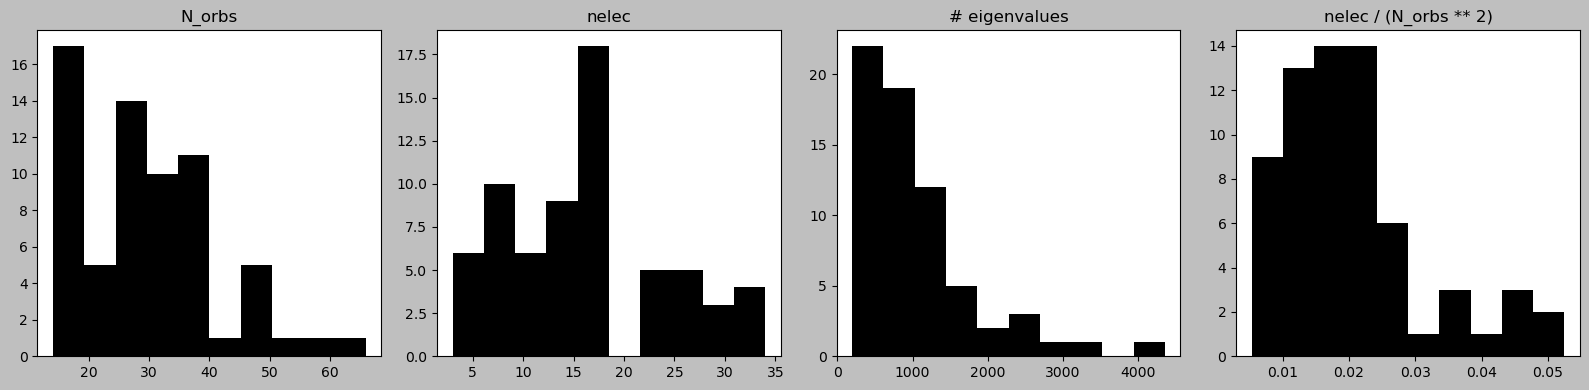

In [7]:
fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(16,4))
axs[0].hist(orbs)
axs[1].hist(nelec)
axs[2].hist(lamb_counts)
axs[3].hist([b / (a*a) for a, b in zip(orbs, nelec)])
axs[0].set_title('N_orbs')
axs[1].set_title('nelec')
axs[2].set_title('# eigenvalues')
axs[3].set_title('nelec / (N_orbs ** 2)')

In [8]:
est = create_density_estimator(get_chk_filenames("chks/", "pVDZ"), ntile=1, num_itr=10000, verbose=True)

Preparing data...


  0%|          | 0/69 [00:00<?, ?it/s]Caught OSError (chks/li_cc-pVDZ_chkfile.chkmetrics.json): Unable to synchronously open file (file signature not found)
Caught OSError (chks/li_cc-pVDZ_chkfile.chk_metrics.json): Unable to synchronously open file (file signature not found)
100%|██████████| 69/69 [00:47<00:00,  1.45it/s]


Fitting density estimator...
Done.


In [9]:
samps = [np.round(s).astype(int).tolist() for s in est.sample(1000, random_state=0)]
s_orbs = [s[0] for s in samps]
s_nelec = [s[1] for s in samps]
s_lamb_counts = [s[2] for s in samps]

Text(0.5, 1.0, 'nelec / (N_orbs ** 2) -- sampled')

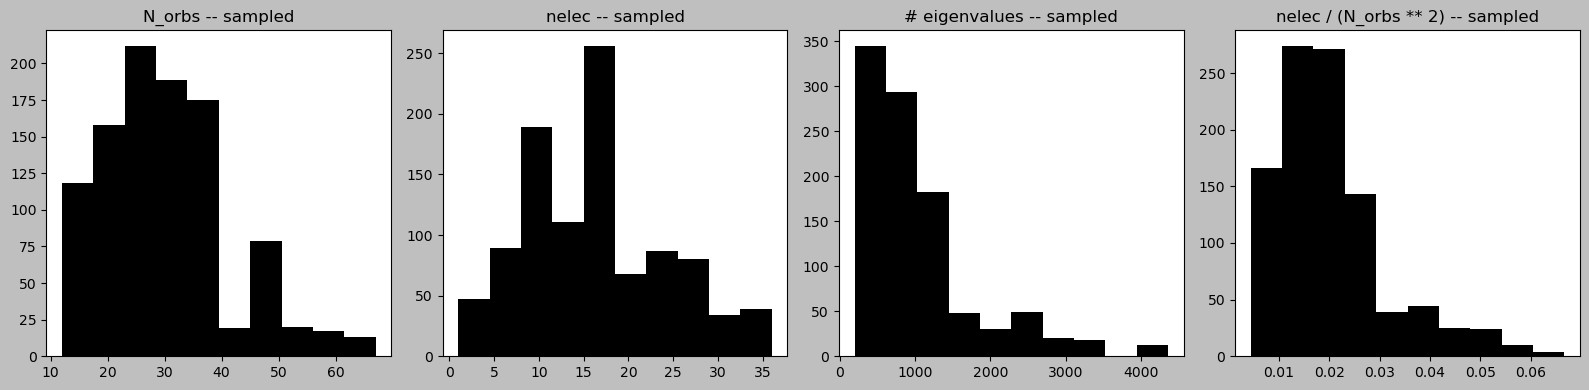

In [10]:
fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(16,4))
axs[0].hist(s_orbs)
axs[1].hist(s_nelec)
axs[2].hist(s_lamb_counts)
axs[3].hist([b / (a*a) for a, b in zip(s_orbs, s_nelec)])
axs[0].set_title('N_orbs -- sampled')
axs[1].set_title('nelec -- sampled')
axs[2].set_title('# eigenvalues -- sampled')
axs[3].set_title('nelec / (N_orbs ** 2) -- sampled')

In [11]:
samps = sorted(samps)

In [12]:
metrics = list()
for s in tqdm(samps[:100]):
    try:
        fm = faux_mol(*s)
        mets = get_mol_metrics(fm)
        metrics.append((fm, mets))
    except:
        continue

  1%|          | 1/100 [00:06<11:19,  6.87s/it]

In [ ]:
metrics[0]

In [ ]:
metrics[0][0]['hf']._eri